### ailen vs predator 데이터셋
- https://www.kaggle.com/datasets/pmigdal/alien-vs-predator-images?resource=download

### Alexnet 활용

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]),
    'validation': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor()
    ])
}

In [5]:
def target_transforms(target):
    return torch.FloatTensor([target])

In [8]:
image_datasets = {
    'train' : datasets.ImageFolder('./dataset/AilenPredator/data/train', data_transforms['train'], target_transform=target_transforms),
    'validation': datasets.ImageFolder('./dataset/AilenPredator/data/validation', data_transforms['validation'], target_transform = target_transforms)
}

In [9]:
dataloaders = {
    'train': DataLoader(
        image_datasets['train'],
        batch_size = 32,
        shuffle = True
    ),
    'validation': DataLoader(
        image_datasets['validation'],
        batch_size = 32,
        shuffle = False
    )
}

In [10]:
len(image_datasets['train']),len(image_datasets['validation'])
# 694,200

(694, 200)

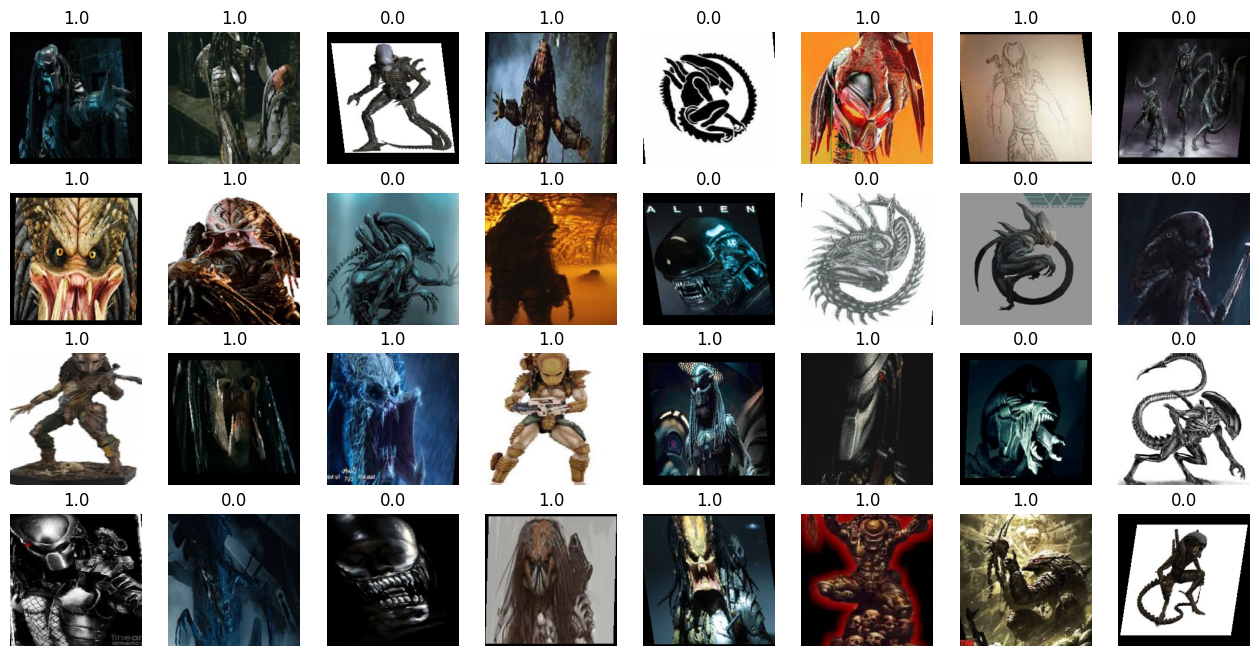

In [11]:
imgs, labels = next(iter(dataloaders['train']))

fig, axes = plt.subplots(4,8, figsize = (16,8))

for ax, img, label in zip(axes.flatten(), imgs, labels):
    ax.imshow(img.permute(1,2,0))
    ax.set_title(label.item())
    ax.axis('off')

In [13]:
model = models.alexnet(weights = 'IMAGENET1K_V1').to(device)
print(model)

0.1%

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\SAMSUNG/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth


100.0%


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
for param in model.parameters():
    param.requires_glad = False

In [18]:
model.classifier = nn.Sequential(
    nn.Linear(256 * 6 * 6, 128),
    nn.ReLU(),
    nn.Linear(128, 1), # 여기선 1로 빼서 확률으로 분류해줌
    nn.Sigmoid()
).to(device)

model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_featur

In [19]:
optimizer = optim.Adam(model.classifier.parameters(), lr= 0.001)# 모델의 classifier의 파라미터만 수정함

In [22]:
epochs = 10

for epoch in range(epochs):
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        sum_losses = 0
        sum_accs = 0

        for x_batch, y_batch in dataloaders[phase]:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            
            y_pred = model(x_batch)
            loss = nn.BCELoss()(y_pred, y_batch)

            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            sum_losses = sum_losses + loss
            y_bool = (y_pred >= 0.5).float()
            acc = (y_batch == y_bool).float().sum()/len(y_batch) * 100
            sum_accs = sum_accs + acc

        avg_loss = sum_losses / len(dataloaders[phase])
        avg_acc = sum_accs / len(dataloaders[phase])
        print(f'{phase:10s}: Epoch {epoch+1:4d}/{epochs} Loss: {avg_loss: .4f} Accuracy: {avg_acc:.2f}%')

train     : Epoch    1/10 Loss:  0.0862 Accuracy: 97.09%
validation: Epoch    1/10 Loss:  0.1543 Accuracy: 93.75%
train     : Epoch    2/10 Loss:  0.0547 Accuracy: 98.23%
validation: Epoch    2/10 Loss:  0.1544 Accuracy: 91.96%
train     : Epoch    3/10 Loss:  0.0783 Accuracy: 97.24%
validation: Epoch    3/10 Loss:  0.2057 Accuracy: 90.62%
train     : Epoch    4/10 Loss:  0.0396 Accuracy: 98.86%
validation: Epoch    4/10 Loss:  0.1743 Accuracy: 92.41%
train     : Epoch    5/10 Loss:  0.0540 Accuracy: 98.37%
validation: Epoch    5/10 Loss:  0.2347 Accuracy: 90.18%
train     : Epoch    6/10 Loss:  0.0558 Accuracy: 98.01%
validation: Epoch    6/10 Loss:  0.2490 Accuracy: 89.73%
train     : Epoch    7/10 Loss:  0.0272 Accuracy: 99.86%
validation: Epoch    7/10 Loss:  0.1929 Accuracy: 91.07%
train     : Epoch    8/10 Loss:  0.0334 Accuracy: 99.65%
validation: Epoch    8/10 Loss:  0.2767 Accuracy: 90.18%
train     : Epoch    9/10 Loss:  0.0420 Accuracy: 98.94%
validation: Epoch    9/10 Loss:

In [23]:
from PIL import Image